# Trabalho Prático 2 de Ciência de Dados 

### Descrição

Comparação de diferentes algoritmos para criação de modelos.

### Objetivos

1. Buscar e utilizar algoritmos não vistos na disciplina para tarefas de Regressão e Classificação.
2. Comparar os algoritmos escolhidos com conjuntos de dados reais utilizando métricas de avaliação vistas ou não na disciplina.

### Equipe formada por
- Bárbara Stéphanie Neves Oliveira, 507526
- Lucas Benjamim Cunha Bandeira, 507533
- Samir Braga Chaves, 513788
- Vinicius Bernardo Gabriel, 475210


# *Brazilian Houses to Rent*

![Kaggle - Brazilian Houses to Rent Dataset](https://i.imgur.com/wOKxor1.pnghttps://i.imgur.com/wOKxor1.png)

O dataset escolhido para realização deste trabalho trata-se do [*Brazilian Houses to Rent*](https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent/code), disponível na comunidade de Ciência de Dados [*Kaggle*: *Your Home for Data Science*](https://www.kaggle.com/).

Escolhemos apenas este *dataset* para a realização do trabalho por possuir *features* (atributos) que podem ser utilizadas tanto para a tafera de Regressão quanto para a tarefa de Classificação.

![Kaggle - Brazilian Houses to Rent Dataset](https://drive.google.com/uc?id=1KgiGRYBMe6tiQWYOJU8vtr-zgGX6aiCj)

# Imports Iniciais

In [5]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

DEFAULT_FONT_SIZE = 14
plt.rcParams['font.size'] = DEFAULT_FONT_SIZE

BASE_PATH = '.'
GRIDS_BASE_DIR = BASE_PATH + '/Grid Results'
MODELS_BASE_DIR = BASE_PATH + '/Best Models'

In [6]:
# Adicionando módulos customizados ao path
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.append(BASE_PATH + '/Modules')
import utils # Carregando funções utilitárias
import models # Carregando modelos

from importlib import reload

# Leitura dos Dados Tratados na Parte 1

In [7]:
df = pd.read_csv(BASE_PATH + '/Dataset/houses_to_rent_v2_treated.csv')

df.head()

,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$),city_pos_0,city_pos_1,city_pos_2,city_pos_3,city_pos_4
0,70,2,1,1,7,1,1,2065,3300,211,42,5618,0,0,0,0,1
1,320,4,4,0,20,1,0,1200,4960,1750,63,7973,0,0,0,0,1
2,80,1,1,1,6,1,0,1000,2800,0,41,3841,0,0,1,0,0
3,51,2,1,0,2,1,0,270,1112,22,17,1421,0,0,1,0,0
4,25,1,1,0,1,0,0,0,800,25,11,836,0,0,0,0,1


In [8]:
print('Número de instâncias = {}'.format(len(df)))
print('Número de atributos = {}'.format(len(df.columns)))

Número de instâncias = 10320
Número de atributos = 17


In [9]:
print('Tipos de cada atributo:\n{}'.format(df.dtypes))

Tipos de cada atributo:
area                   int64
rooms                  int64
bathroom               int64
parking spaces         int64
floor                  int64
animal                 int64
furniture              int64
hoa (R$)               int64
rent amount (R$)       int64
property tax (R$)      int64
fire insurance (R$)    int64
total (R$)             int64
city_pos_0             int64
city_pos_1             int64
city_pos_2             int64
city_pos_3             int64
city_pos_4             int64
dtype: object


# Parte 2. Tarefas de Regressão e Classificação

## Definição dos Problemas

- **Tarefa de Regressão:**
> A tarefa de Regressão é usada para prever um valor de um conjunto de atributos relacionados. O valor pode ser de qualquer tipo real e não pertence a um conjunto finito. No caso do *Brazilian Houses to Rent Dataset*, temos o sequinte cenário para a tarefa de Regressão:
> - Cenário - Regressão: predição do preço total das casas com base nos seus atributos.
>
> Como visto na Parte 1 deste trabalho, os valores dos atributos `hoa (R$)`, `rent amount (R$)`, `property tax (R$)` e `fire insurance (R$)` são somados para formar o atributo `total (R$)`. Esses atributos também estão positivamente correlacionados, isto é, qualquer um deles sobe com o aumento do valor de outro. Assim, usaremos apenas `total (R$)` para a tarefa de Regressão. 

- **Tarefa de Classificação:**
> A tarefa de Classificação atribui os padrões encontrados nos dados a certas categorias. Dependendo do problema, ela pode ser de diferentes tipos: classificação binária, multiclasse e multirótulo. No caso do *Brazilian Houses to Rent Dataset*, temos três cenários para a tarefa de Classificação:
> - Cenário 1 - Classificação Multiclasse: dizer qual cidade que uma casa está disponível para aluguel.
> - Cenário 2 - Classificação Binária: categorizar se uma casa aceita ou não animais.
> - Cenário 3 - Classificação Binária: categorizar se uma casa está ou não mobiliada.
>
> Como problema, escolhemos os cenários 2 e 3. Inicialmente, tentamos uní-los para tratar como um problema de Classificação Multirótulo (uma casa poderia ser categorizada em se aceita ou não animais e se possui ou não mobília, por exemplo), mas achamos melhor manter o padrão dos dados e resolver cada cenário separadamente.
>
> Na Parte 1 do trabalho, mostramos que os dados dos atributos categóricos estão desbalanceados. Para tratar esse problema, na separação dos dados em treino e teste, utilizamos o processo de [estratificação](https://en.wikipedia.org/wiki/Stratified_sampling). Assim, conseguimos manter a proporção de cada classe nos conjuntos de treino e teste.

## Métricas de Avaliação

A seguir, estão descritas as métricas que serão utilizadas para avaliar os modelos deste trabalho, de acordo com cada uma das tarefas de aprendizado.

### Regressão 

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

As métricas importadas acima avaliam modelos de Regressão e são usadas aqui com este fim. 

- ***Mean Squared Error* (MSE):** calcula o erro médio quadrático entre os valores preditos e os valores reais, logo, objetiva-se minimizá-lo. Os valores possíveis dependem do contexto do problema em que os dados pertencem. Essa métrica é comumente utilizada para traçar a curva de aprendizado do modelo ao longo das iterações. Sua fórmula é

<h4 align="center">$\textrm{MSE} = \frac{1}{n}\sum_{i = 1}^{n} (y - \hat{y})²$</h4>

- ***Root Mean Squared Error* (RMSE):** é calculado apenas aplicando a raiz quadrada ao MSE, dada pela fórmula a seguir.

<h4 align="center">$\textrm{RMSE} = \sqrt{\textrm{MSE}}$</h4>

- ***Mean Absolute Error* (MAE):** calcula o erro médio absoluto entre os valores preditos e os valores reais.

<h4 align="center">$\textrm{MAE} = \frac{1}{n}\sum_{i = 1}^{n} |y - \hat{y}|$</h4>

- ***R-Squared* (R²):** representa a proporção da variância (de *y*) que foi explicada pelas variáveis independentes no modelo. O R² fornece uma indicação da qualidade da convergência e, portanto, é uma medida do quão bem as amostras não vistas podem ser previstas pelo modelo, por meio da proporção da variância explicada.

<h4 align="center">
  $R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$
</h4>
<h4 align="center">
  $\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i$
</h4>

### Classificação 

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

As métricas importadas na célula anterior são bastante comuns para a avaliação de modelos para tarefas de Classificação, em especial a Classificação Binária. Todas são funções com domínio no intervalo [0-1], sendo **0** o pior e **1** o melhor. As definições das métricas estão listadas a seguir.

- ***Precision* (*P*):** avalia quanto dos elementos selecionados são "relevantes", ou seja, quantos dos quais o modelo afirmou serem positivos são realmente positivos. Sua fórmula é

<h4 align="center">$P = \frac{\textrm{Verdadeiros Positivos}}{\textrm{Verdadeiros Positivos + Falsos Positivos}}$</h4>

- ***Recall* (*R*):** avalia quantos elementos "relevantes" foram selecionados, ou seja, dentre todos os sabidamente positivos quantos o modelo afirmou serem positivos. 

<h4 align="center">$R = \frac{\textrm{Verdadeiros Positivos}}{\textrm{Verdadeiros Positivos + Falsos Negativos}}$</h4>

- ***F1-score* (*F*$_1$):** tem o propósito de baleancar as métricas *P* e *R*. Essa necessidade surge pois os resultados de ambas as métricas podem ser fortemente influenciados pela distribuição das classes. Por exemplo, em um modelo que retorna sempre uma predição positiva terá *Recall* igual a 1, enquanto o *Precision* será bem baixo. 


<h4 align="center">$F_1 = 2 \cdot \frac{P \times R}{P + R}$</h4>

- ***Accuracy*:** a acurácia calcula a taxa de acertos, ou seja, indenpendente da classe predita, quantos valores o modelo acertou.


<h4 align="center">$Accuracy = \frac{\textrm{elementos preditos corretamente}}{\textrm{total de elementos}} $</h4>

- ***Binary Cross Entropy* (*BCE*):** função de custo usada na Regressão Logística (multinomial). Por ser utilizada para a convergência do modelo, também pode avaliar seu desempenho. A diferença das demais é que ela é calculada a partir das probabilidades da predição de cada classe e não apenas sobre a classe final. Sua fórmula é dada por:


<h4 align="center">$L_{\log}(y, p) = -(y \log (p) + (1 - y) \log (1 - p))$
</h4>

## Treinamento dos Modelos

Na disciplina, vimos alguns algoritmos para criação de modelos, como Regressão Linear e Logística, e K-Vizinhos Mais Próximos (KNN). Além desses algoritmos, iremos usar para experimentação alguns dos modelos mais populares e que já alcançaram o estado da arte. 

Para deixar nossa experimentação mais consistente, realizaremos as seguintes etapas:

<center>
  <img width="800" src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/kfold-selection.png" />
</center>

A descrição detalhada da figura pode ser encontrada neste [*link*](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part3.html). Resumiremos aqui cada passo trazendo mais para o contexto deste trabalho.

> 1. Separação dos dados em treino e teste, de acordo com a tarefa. O conjunto de teste é "guardado" para a etapa final de comparação dos melhores modelos.
2. Para a **comparação inicial** da perfomance de cada modelo, a experimentação consiste em otimizar os parâmetros através de uma ***Grid Search***. Para cada *grid*/configuração de hiperparâmetros, é aplicado o método ***cross-validation***¹ no conjunto de treino, resultando assim em vários modelos e estimativas de desempenho. Dependendo do algoritmo do modelo (se Regressão Linear, KNN, etc.), é explicada a escolha por trás da *grid* de parâmetros.
3. De acordo com os resultados obtidos com a *cross-validated grid-search* para cada uma das métricas de avaliação, é escolhido o melhor modelo. Na verdade, para facilitar, uma **métrica padrão** é escolhida para servir como critério de escolha deste melhor modelo.
4. Por fim, é feita a **comparação final** dos melhores modelos para cada uma das tarefas usando o seu respectivo **conjunto de teste**.
5. Como não será necessário colocar nada em produção (*deployment*), não é preciso realizar este passo :)

Neste *notebook*, realizaremos as etapas 1, 2 e 3, e salvaremos os modelos e os conjuntos de teste para serem usados na Parte 3 deste trabalho. A explicação de cada um dos algoritmos não vistos na disciplina estão em seus respectivos tópicos, a seguir, separados de acordo com a tarefa de aprendizado.

¹ Especificamente, escolhemos separar em 3-*folds*, pois além de 3 ser divisor de 10.320 (tamanho do *dataset*), como não temos muitos dados, um grande valor para *k* não seria uma boa escolha. Geralmente, um *k* muito grande significa que apenas um número baixo de combinações da amostra é possível, limitando assim o número de iterações possíveis em cada *fold*.



### Regressão

Para a **tarefa de Regressão**, além dos modelos de Regressão Linear e KNN dados na disciplina, usaremos Árvores de Decisão (*Decision Tree*) e *Support Vector Machines* (SVM). A justificava do porque usaremos esses modelos e os resultados das *Grids Search* estarão em suas respectivas seções. 

Em relação ao atributos e o valor alvo para predição, as colunas `city`, `area`, `rooms`, `bathroom`, `parking spaces`, `floor`, `animal` e `furniture` serão nosso *X*, enquanto que o nosso *y* será a coluna `total (R$)`, como já explicado anteriormente.

Nas *Grids Search* abaixo, os melhores modelos são os que estão presentes no índice 0 de cada *dataframe*.

In [12]:
# X = city, area, rooms, bathroom, parking spaces, floor, animal e furniture
# y (target) = total (R$)
REGRESSION_LEARNING_COLUMNS = df.columns[:7].tolist() + ["city_pos_0", "city_pos_1", "city_pos_2", "city_pos_3", "city_pos_4"]
REGRESSION_TARGET_COLUMN = "total (R$)"

print(f"Atributos usados no treino da Regressão = {REGRESSION_LEARNING_COLUMNS}")
print(f"Atributo alvo da Regressão = {REGRESSION_TARGET_COLUMN}")

X_reg, y_reg = df[REGRESSION_LEARNING_COLUMNS].values, df[REGRESSION_TARGET_COLUMN].values 

Atributos usados no treino da Regressão = ['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'animal', 'furniture', 'city_pos_0', 'city_pos_1', 'city_pos_2', 'city_pos_3', 'city_pos_4']
Atributo alvo da Regressão = total (R$)


In [13]:
# Separando os dados nos conjuntos de treino e teste para Regressão 
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=.2, random_state=42)

# Salvando o conjunto de teste
utils.save_sets(X_test_reg, y_test_reg, BASE_PATH + '/Dataset/test_set_regression.json')

X_train_reg.shape, X_test_reg.shape, y_train_reg.shape, y_test_reg.shape

((8256, 12), (2064, 12), (8256,), (2064,))

- **Métrica padrão:**

> Usaremos a RMSE como critério para escolher o melhor modelo, pois:
> 1. É usada mais que a MSE porque às vezes o valor da MSE pode ser muito grande.
> 2. A MSE é calculada obtendo o quadrado do erro e, portanto, a raiz quadrada da RMSE traz de volta o mesmo nível do erro de predição. Além disso, a RMSE é a métrica  utilizada pelo *Kaggle* para avaliar as submissões de problemas de Regressão. Também, como este problema envolve preços de aluguéis, a RMSE é mais interessante do que a MAE neste sentido, por penalizar mais erros maiores, que são indesejados.

In [14]:
reg_score_metrics = {
    'root_mean_squared_error': make_scorer(utils.rmse, greater_is_better=False), 
    'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2_error': make_scorer(r2_score)
}

reg_best_criteria = 'root_mean_squared_error'

In [15]:
reg_models_dir = MODELS_BASE_DIR + "/Regression"
reg_grids_dir = GRIDS_BASE_DIR + "/Regression"
reg_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Criação das Grids Search e seleção dos melhores modelos de acordo com a RMSE
best_regression_models = models.train_regression_models(needs_to_train=True, 
                                                        models_path=reg_models_dir, 
                                                        X_train=X_train_reg, 
                                                        y_train=y_train_reg, 
                                                        score_metrics=reg_score_metrics, 
                                                        cv=reg_cv, 
                                                        best_criteria=reg_best_criteria, 
                                                        grids_path=reg_grids_dir)

best_regression_models

[DONE] Treino e geração da GridSearch do modelo Regressão Linear --> 0.026829004287719727 segundos
[DONE] Treino e geração da GridSearch do modelo KNN para Regressão --> 12.196754932403564 segundos
[DONE] Treino e geração da GridSearch do modelo Árvore de Decisão para Regressão --> 4.763818979263306 segundos
[DONE] Treino e geração da GridSearch do modelo SVM para Regressão --> 487.11255288124084 segundos

Salvando os resultados das grids search de cada modelo...
Salvando os melhores modelos...


{'linear_regression': LinearRegression(normalize=True),
 'knn': KNeighborsRegressor(metric='manhattan', n_neighbors=25, weights='distance'),
 'decision_tree': DecisionTreeRegressor(),
 'svr': Pipeline(steps=[('scaler', StandardScaler()),
                 ('svr', SVR(C=3000, gamma='auto'))])}

#### Regressão Linear

In [16]:
pd.read_csv(reg_grids_dir + '/linear_regression.csv')

,mean_test_root_mean_squared_error,mean_test_mean_squared_error,mean_test_mean_absolute_error,mean_test_r2_error,params
0,2758.896741,7.616808e+06,1802.487424,0.627866,{}


#### KNN

- **Combinações de hiperparâmetros utilizadas:**
> - `n_neighbors` = `range(5, 51, 5)` 
>    - Pelo o que sabemos, não existem métodos estatísticos predefinidos para encontrar o valor mais favorável dos *k*-vizinhos mais próximos. Talvez, o método mais recomendado seja o [Método do Covotelo (*Elbow Curve*)](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). 
>    - Definimos os números de vizinhos começando de 5 (padrão do *Scikit-learn*) e indo de 5 em 5 até 50. Sabemos que essa também é uma maneira de identificar qual o *k* ideal.
> - `weights` = `['uniform', 'distance']`
>    - Indica a função de peso ou kernel. Os *k*-pontos mais próximos recebem um peso de acordo com essa função. 
>    - O padrão do [*Scikit-learn*](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) é o `uniform`, ou seja, todos os pontos são ponderados igualmente. Outra opção que consideramos como hiperparâmetro é usar o `distance`. A intuição por trás do `distance` é dar mais peso aos pontos que estão próximos e menos peso aos pontos que estão mais distantes. 
> - `metric` = `['euclidean', 'manhattan', 'chebyshev']`
>    - Consideramos como métricas de distâncias as [mais populares](https://www.kdnuggets.com/2020/11/most-popular-distance-metrics-knn.html) e disponíveis pela biblioteca. A métrica é um dos fatorores mais importantes, já que decide quem será considerado como vizinho mais próximo.

Por padrão, o *Scikit-learn* seleciona o algoritmo mais apropriado (`BallTree`, `KDTree`, etc.) para computar os vizinhos mais próximos com base nos valores passados ​​para o modelo. Sabemos mais ou menos as diferenças de cada algoritmo, mas preferimos deixar que o método do *Scikit-learn* faça a escolha.

In [17]:
df_grid_reg_knn = pd.read_csv(reg_grids_dir + '/knn.csv')
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_reg_knn)))
df_grid_reg_knn.head()

Quantidade de combinações possíveis dos modelos da grid = 60 modelos


,mean_test_root_mean_squared_error,mean_test_mean_squared_error,mean_test_mean_absolute_error,mean_test_r2_error,params
0,2793.079284,7.805025e+06,1781.468624,0.618571,"{'metric': 'manhattan', 'n_neighbors': 25, 'we..."
1,2794.359613,7.812275e+06,1779.583091,0.618223,"{'metric': 'manhattan', 'n_neighbors': 20, 'we..."
2,2797.100894,7.827676e+06,1787.097855,0.617472,"{'metric': 'manhattan', 'n_neighbors': 30, 'we..."
3,2797.451166,7.829686e+06,1777.407955,0.617380,"{'metric': 'manhattan', 'n_neighbors': 15, 'we..."
4,2797.932112,7.832721e+06,1790.724776,0.617251,"{'metric': 'manhattan', 'n_neighbors': 35, 'we..."


#### Árvores de Decisão

Como o nome sugere, as Árvores de Decisão utilizam a estrutura de árvoce para representar o conhecimento adquirido em um processo de aprendizado. Cada nó interno divide uma dimensão dos dados em um determinado limiar, como pode ser observado na figura abaixo.

<center>
  <img width="375" src="https://dinhanhthi.com/img/post/ML/random-forest-decision-tree/r2.jpg" />
</center>

A construção da árvore é realizada automaticamente a partir dos próprios dados, geralmente utilizado uma heurística "gulosa", a qual baseia-se em:
1. Iniciar com uma árvore vazia;
2. Encontrar o melhor atributo para realizar uma divisão;
3. Repitir recursivamente o passo anterior para o próximo nó até
encontrar uma folha.

Assim, na Regressão, os dados são separados em diversos nós para cada atributo dependente. Nesses nós, é feita a média do erro entre os valores preditos e os valores reais. O nó que obtiver o menor valor é escolhido para divisão. Para encontrar o melhor atributo, utilizam-se métricas de pureza de um nó, como as descritas abaixo.

- **Combinações de hiperparâmetros utilizadas:**
> - `criterion` = `['mse', 'mae']`
>    - Mede a qualidade de como os nós da árvore podem ser divididos. Os métodos escolhidos se tratam de métricas para a Regressão, já explicadas neste trabalho. 
> - `splitter` = `['best', 'random']`
>    - O `splitter` indica a estratégia usada para escolher a divisão de cada nó da árvore. As estratégias disponíveis pelo [*Scikit-learn*](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) são `best`, que escolhe a melhor divisão, e `random`, que escolhe a melhor divisão aleatoriamente.

In [18]:
df_grid_reg_dt = pd.read_csv(reg_grids_dir + '/decision_tree.csv')
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_reg_dt)))
df_grid_reg_dt.head()

Quantidade de combinações possíveis dos modelos da grid = 4 modelos


,mean_test_root_mean_squared_error,mean_test_mean_squared_error,mean_test_mean_absolute_error,mean_test_r2_error,params
0,3565.536735,1.271573e+07,2191.289762,0.378254,"{'criterion': 'mse', 'splitter': 'best'}"
1,3631.720593,1.320499e+07,2219.437682,0.353907,"{'criterion': 'mae', 'splitter': 'best'}"
2,3664.402990,1.343947e+07,2224.427265,0.341329,"{'criterion': 'mae', 'splitter': 'random'}"
3,3683.670695,1.357060e+07,2239.115377,0.335813,"{'criterion': 'mse', 'splitter': 'random'}"


#### SVM

*Support Vector Machines* (SVM) é um algoritmo de Aprendizado Supervisionado
que constrói hiperplanos para mapear vetores de entrada em espaços não lineares de alta dimensionalidade. Cada dimensão deste espaço corresponde a um atributo do conjunto de dados de entrada. Ele é bastante utilizado para problemas de Classificação, mas pode ser adaptado para problemas de Regressão. No *Scikit-learn*, para a tarefa de Regressão, ele é chamado de [*Support Vector Regression* (SVR)](https://scikit-learn.org/stable/modules/svm.html#regression). 

Após a construção dos hiperplanos com o SRV, a regressão é realizada através da busca de um hiperplano ótimo, ou seja, o que possui o melhor desempenho e apresenta a menor margem de erro.

<center><img src="https://miro.medium.com/max/606/1*CgDvkD7OtXVhOScMpyMKsw.png"/></center>

Observe na figura acima que a linha vermelha representa o hiperplano *C* que possui o melhor *fit* e as linhas pretas representam a margem de erro, dada por ϵ. Na Regressão, o objetivo é achar o melhor valor para *C*. Na figura, *C* é igual a 6.13 e está fora da taxa de erro aceitável (ϵ=5). Este [*link*](https://towardsdatascience.com/an-introduction-to-support-vector-regression-svr-a3ebc1672c2) possui mais detalhes sobre o funcionamento do SVR.

- **Combinações de hiperparâmetros utilizadas:**
> - `kernel` = `['linear', 'poly', 'rbf', 'sigmoid']`
>    - A principal função do `kernel` é transformar o espaço de entrada de baixa dimensão em um espaço de alta dimensão. Queremos testar se o nosso problema possui uma separação não linear, assim, além de considerarmos `linear` como `kernel`, também testamos as seguintes funções:
    <center><img width="650" src="https://miro.medium.com/max/1380/1*AFqQio7ZB91FZvFtuYAn-w.png"/></center>
> - `C` = `[0.1, 1, 10, 100, 1000, 3000]`
>    - C é o parâmetro de penalidade, que representa o *error term*. Ele é o que informa à otimização do SVM a quantidade de erro suportável. Exemplos:
      <center><img width="700" src="https://miro.medium.com/max/1000/0*08KrYhXpVQdUXWrX"/></center>
> - `gamma` = `['scale', 'auto']`
>    - Define até que ponto o cálculo da linha de separação pode influenciar. Quando o `gamma` é maior, os pontos próximos terão grande influência; um `gamma` baixo significa que pontos distantes também devem ser considerados para obter o limite de decisão.
>    - `scale` e `auto` são as opções disponíveis no [*Scikit-learn*](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html).
    <center><img width="650" src=" https://miro.medium.com/max/1713/1*6HVomcqW7BWuZ2vvGOEptw.png"/></center>

Imagens retiradas deste [*link*](https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/).
        

In [19]:
df_grid_reg_svr = pd.read_csv(reg_grids_dir + '/svr.csv')
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_reg_svr)))
df_grid_reg_svr.head(10)

Quantidade de combinações possíveis dos modelos da grid = 48 modelos


,mean_test_root_mean_squared_error,mean_test_mean_squared_error,mean_test_mean_absolute_error,mean_test_r2_error,params
0,2609.012698,6.811099e+06,1585.250893,0.667195,"{'svr__C': 3000, 'svr__gamma': 'auto', 'svr__k..."
1,2609.012699,6.811099e+06,1585.250895,0.667195,"{'svr__C': 3000, 'svr__gamma': 'scale', 'svr__..."
2,2636.477729,6.955315e+06,1596.230424,0.660155,"{'svr__C': 1000, 'svr__gamma': 'auto', 'svr__k..."
3,2636.477734,6.955315e+06,1596.230426,0.660155,"{'svr__C': 1000, 'svr__gamma': 'scale', 'svr__..."
4,2776.905863,7.724829e+06,1660.795420,0.622905,"{'svr__C': 3000, 'svr__gamma': 'scale', 'svr__..."
5,2776.905870,7.724829e+06,1660.795422,0.622905,"{'svr__C': 3000, 'svr__gamma': 'auto', 'svr__k..."
6,2816.031943,7.943858e+06,1685.499629,0.612226,"{'svr__C': 1000, 'svr__gamma': 'auto', 'svr__k..."
7,2816.031943,7.943858e+06,1685.499629,0.612226,"{'svr__C': 1000, 'svr__gamma': 'scale', 'svr__..."
8,2829.851545,8.015197e+06,1733.983271,0.608478,"{'svr__C': 3000, 'svr__gamma': 'auto', 'svr__k..."
9,2829.851545,8.015197e+06,1733.983271,0.608478,"{'svr__C': 3000, 'svr__gamma': 'scale', 'svr__..."


### Classificação

Para a **tarefa de Classificação**, além dos modelos de Regressão Logística e KNN dados na disciplina, usaremos Árvores de Decisão (*Decision Tree*), *Naive Bayes* e *Support Vector Machines* (SVM). A justificava do porque usaremos esses modelos e os resultados das *Grids Search* estarão em suas respectivas seções.

Em relação aos atributos e o valor alvo para predição, as colunas `city`, `area`, `rooms`, `bathroom`, `parking spaces`, `floor`, `animal` e `furniture` serão nosso *X*, enquanto que os nossos *y*'s serão as colunas `animal` e `furniture`.

Nas *Grids Search* abaixo, os melhores modelos são os que estão presentes no índice 0 de cada *dataframe*.

In [20]:
# X = city, area, rooms, bathroom, parking spaces, floor e total (R$)
# y (target) = furniture e animal
CLASSIFICATION_LEARNING_COLUMNS = df.columns[:5].tolist() + df.columns[-6:].tolist()
CLASSIFICATION_TARGET_COLUMN = ["furniture", "animal"]
print(f"Colunas usadas no treino da Classificação = {CLASSIFICATION_LEARNING_COLUMNS}")
print(f"Alvos da Classificação = {CLASSIFICATION_TARGET_COLUMN}")

X_classif, y_classif = df[CLASSIFICATION_LEARNING_COLUMNS].values, df[CLASSIFICATION_TARGET_COLUMN].values 

Colunas usadas no treino da Classificação = ['area', 'rooms', 'bathroom', 'parking spaces', 'floor', 'total (R$)', 'city_pos_0', 'city_pos_1', 'city_pos_2', 'city_pos_3', 'city_pos_4']
Alvos da Classificação = ['furniture', 'animal']


### Atributo Animal

In [21]:
X_animal = np.c_[X_classif, y_classif[:, 0]]
y_animal = y_classif[:, 1]

X_train_animal, X_test_animal, y_train_animal, y_test_animal = train_test_split(X_animal, 
                                                                                y_animal, 
                                                                                test_size=.2, 
                                                                                random_state=42,
                                                                                stratify=y_animal) # Estratificando os dados

# Salvando o conjunto de teste
utils.save_sets(X_test_animal, y_test_animal, BASE_PATH + '/Dataset/test_set_classification_animal.json')

X_train_animal.shape, X_test_animal.shape, y_train_animal.shape, y_test_animal.shape

((8256, 12), (2064, 12), (8256,), (2064,))

- **Distribuição das classes:**
> Podemos ver no gráfico abaixo que a proporção das classes do conjunto de dados original foi preservada após a divisão em treino e teste. A este processo dá-se o nome de estratificação. Exemplo para a classe `accept`: 78% do conjunto de dados possui à classe `accept`, e após a estratificação o conjunto treino manteve os 78% e o conjunto de teste ficou com 71%, o que é um valor aproximado.

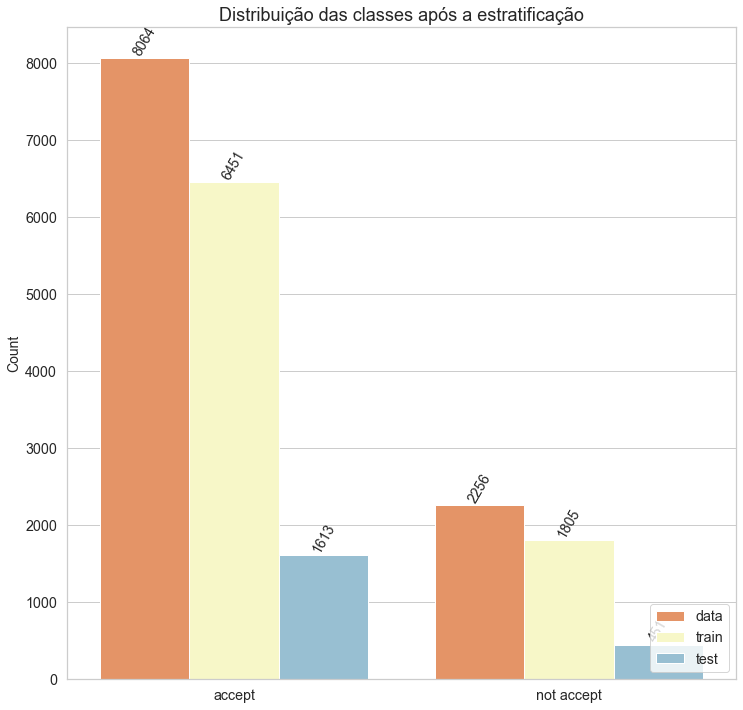

In [22]:
# Verificando a estratificação
utils.plot_labels_distribution("Distribuição das classes após a estratificação",
                               y_animal,
                               y_train_animal,
                               y_test_animal,
                               labels=["accept", "not accept"])

In [23]:
classif_score_metrics = {
    'accuracy': make_scorer(accuracy_score), 
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'log_loss': make_scorer(log_loss, greater_is_better=False),
}

# Usaremos o F1-score como critério para escolher o melhor modelo, já que ele é a média harmônica do Precision e Recall  
# Ele nos dá um valor de desempenho mais coerente do que a acurária
# O F1 é altamente utilizado em competições e artigos científicos
classif_best_criteria = 'f1_score'

In [24]:
label_animal = 'animal'
classif_animal_models_dir = MODELS_BASE_DIR + "/Classification/Animal"
classif_animal_grids_dir = GRIDS_BASE_DIR + "/Classification/Animal" 
classif_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Criação das Grids Search e seleção dos melhores modelos de acordo com o F1
best_classification_animal_models = models.train_classification_models(needs_to_train=True, # Carrega os modelos treinados
                                                                       models_path=classif_animal_models_dir,
                                                                       X_train=X_train_animal, 
                                                                       y_train=y_train_animal, 
                                                                       score_metrics=classif_score_metrics, 
                                                                       cv=classif_cv, 
                                                                       best_criteria=classif_best_criteria, 
                                                                       grids_path=classif_animal_grids_dir, 
                                                                       label=label_animal)
best_classification_animal_models

[DONE] Treino e geração da GridSearch do modelo Regressão Logística --> 9.898905992507935 segundos
[DONE] Treino e geração da GridSearch do modelo KNN para Classificação --> 93.2746696472168 segundos
[DONE] Treino e geração da GridSearch do modelo Árvore de Decisão para Classificação --> 0.39644789695739746 segundos
[DONE] Treino e geração da GridSearch do modelo Naive Bayes para Classificação --> 0.25806689262390137 segundos
[DONE] Treino e geração da GridSearch do modelo SVM para Classificação --> 139.0799150466919 segundos

Salvando os resultados das grids search de cada modelo...
Salvando os melhores modelos...


{'animal_logistic_regression': Pipeline(steps=[('scaler', StandardScaler()),
                 ('LR',
                  LogisticRegression(C=0.001, penalty='none',
                                     solver='newton-cg'))]),
 'animal_knn': Pipeline(steps=[('scaler', StandardScaler()),
                 ('KNN',
                  KNeighborsClassifier(metric='euclidean', n_neighbors=45))]),
 'animal_decision_tree': DecisionTreeClassifier(),
 'animal_naive_bayes': GaussianNB(var_smoothing=1e-07),
 'animal_svc': Pipeline(steps=[('scaler', StandardScaler()),
                 ('SVC',
                  BaggingClassifier(base_estimator=SVC(C=10, gamma='auto'),
                                    max_samples=0.06666666666666667,
                                    n_estimators=15))])}

#### Regressão Logística

- **Combinações de hiperparâmetros utilizadas:**
> - `solver` = `['newton-cg', 'lbfgs', 'liblinear', 'sg', 'saga']`
>    - O `solver` seleciona o algoritmo que pode ser usado para a otimização do problema, isto é, ele é usado para minimizar a função de custo de forma que seja obtido o melhor resultado. Escolhemos para a *grid* todos os algoritmos disponíveis pelo [*Scikit-learn*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Uma explicação mais detalhada destes algoritmos pode ser encontrada neste [*link*](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions).
> - `penalty` = `['none', 'l1', 'l2', 'elasticnet']`
>    - Parâmetro que especifica a norma usada na regularização. Resumidamente, a regularização é aplicada como forma de penalidade ao aumento da magnitude dos valores dos parâmetros, a fim de reduzir o *overfitting*. A norma utilizada para regularização é importante pois ela diminui os pesos associados às características (os *X*'s) que influenciam menos no resultado. Também usaremos todas as disponíveis pelo *Scikit-learn*.
> - `C` = `[0.001, .009, 0.01, .09, 1, 5, 10, 25, 100, 250]`
>    - Como forma de minimizar o erro, o *C* é adicionado ao que está sendo minimizado, como também minimiza a norma da regularização para penalizar grandes valores dos parâmetros. Usar o *C* também evita que o modelo possua muitos parâmetros (muitas variáveis ​​independentes), mas poucos dados.
>    - Basicamente, escolhemos valores grandes e pequenos para o *C*. Um valor grande dá mais liberdade para o modelo na geração de grandes parâmetros, enquanto que um valor pequeno restringe esta característica.

In [25]:
df_grid_logreg_animal = pd.read_csv(classif_animal_grids_dir + '/' + label_animal + '_logistic_regression.csv')
# Dropando os valores NaN. Para fazermos todas as combinações possíveis, dependendendo dos parâmetros, alguns modelos falham ao realizar o fit
  # Por exemplo: o solver lbfgs não consegue lidar com as penalties L1 ou ElasticNet
df_grid_logreg_animal.dropna(inplace=True)
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_logreg_animal)))
df_grid_logreg_animal.head()

Quantidade de combinações possíveis dos modelos da grid = 90 modelos


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1_score,mean_test_log_loss,params
0,0.782703,0.782482,0.999845,0.877909,-7.505329,"{'LR__C': 0.001, 'LR__penalty': 'none', 'LR__s..."
1,0.782703,0.782482,0.999845,0.877909,-7.505329,"{'LR__C': 1, 'LR__penalty': 'l1', 'LR__solver'..."
2,0.782703,0.782482,0.999845,0.877909,-7.505329,"{'LR__C': 25, 'LR__penalty': 'l1', 'LR__solver..."
3,0.782703,0.782482,0.999845,0.877909,-7.505329,"{'LR__C': 1, 'LR__penalty': 'l1', 'LR__solver'..."
4,0.782703,0.782482,0.999845,0.877909,-7.505329,"{'LR__C': 25, 'LR__penalty': 'l2', 'LR__solver..."


#### KNN

As **combinações de hiperparâmetros** utilizadas se tratam das mesmas que foram escolhidas para na tarefa de Regressão.

In [26]:
df_grid_knn_animal = pd.read_csv(classif_animal_grids_dir + '/' + label_animal + '_knn.csv')
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_knn_animal)))
df_grid_knn_animal.head()

Quantidade de combinações possíveis dos modelos da grid = 60 modelos


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1_score,mean_test_log_loss,params
0,0.788154,0.798958,0.973957,0.877819,-7.317052,"{'KNN__metric': 'euclidean', 'KNN__n_neighbors..."
1,0.788639,0.802362,0.967911,0.877392,-7.300314,"{'KNN__metric': 'manhattan', 'KNN__n_neighbors..."
2,0.787912,0.800125,0.971167,0.877385,-7.325418,"{'KNN__metric': 'manhattan', 'KNN__n_neighbors..."
3,0.788639,0.802444,0.967756,0.877378,-7.300314,"{'KNN__metric': 'manhattan', 'KNN__n_neighbors..."
4,0.787427,0.799412,0.971787,0.877208,-7.342152,"{'KNN__metric': 'euclidean', 'KNN__n_neighbors..."


#### Árvores de Decisão

A explicação para Árvore de Decisão dada na Regressão também vale para a tarefa de Classificação, mas com duas diferenças principais, que podem ser notadas na figura abaixo.

<center>
  <img width="450" src="https://www.researchgate.net/profile/Nick-Bassiliades/publication/337413360/figure/fig2/AS:827514800836608@1574306311071/A-simple-decision-tree-classifier-with-4-features.ppm" />
</center>

1. A árvore divide o conjunto de dados com base na homogeneidade dos dados. 
2. As medidas de impureza, diferentemente das métricas para a Regressão, são usadas para quantificar a homogeneidade dos dados quando se trata de árvores para Classificação.

- **Combinações de hiperparâmetros utilizadas:**
> - `criterion` = `['gini', 'entropy']`
>    - Mede a qualidade de como os nós da árvore podem ser divididos. Os critérios suportados pelo [*Scikit-learn*](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) são `gini` para a impureza de Gini e `entropy` para o ganho de informação.
> - `splitter` = `['best', 'random']`
>    - O `splitter` indica a estratégia usada para escolher a divisão em cada nó da árvore. As estratégias disponíveis pelo *Scikit-learn* são `best`, que escolhe a melhor divisão, e `random`, que escolhe a melhor divisão aleatoriamente.

In [27]:
df_grid_dt_animal = pd.read_csv(classif_animal_grids_dir + '/' + label_animal + '_decision_tree.csv')
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_dt_animal)))
df_grid_dt_animal.head()

Quantidade de combinações possíveis dos modelos da grid = 4 modelos


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1_score,mean_test_log_loss,params
0,0.694767,0.807753,0.799720,0.803696,-10.542478,"{'criterion': 'gini', 'splitter': 'best'}"
1,0.688227,0.806197,0.791194,0.798608,-10.768386,"{'criterion': 'entropy', 'splitter': 'best'}"
2,0.685925,0.804850,0.789490,0.797094,-10.847872,"{'criterion': 'gini', 'splitter': 'random'}"
3,0.678173,0.800406,0.783442,0.791784,-11.115617,"{'criterion': 'entropy', 'splitter': 'random'}"


#### Naive Bayes

*Naive Bayes* faz parte de um conjunto de classificadores bayesianos cujo o propósito é predizer a probabilidade de um padrão pertencer a cada uma das classes. Enquanto modelos discriminantes, como a Regressão Logística, aprendem diretamente a distribuição $p(y_i|\pmb{x_i})$, os modelos generativos modelam a distribuição das entradas associadas a cada classe. 

No caso dos classificadores bayesianos, estes consideram um modelo para $p(\pmb{x_i}|y_i)$, definem uma *priori* para $p(y_i)$ e aplicam a regra de *Bayes* para obter $p(y_i|\pmb{x_i})$. A *priori* pode ser escolhida tanto pela proporção dos dados de cada classe no conjunto de treino, quanto por um conhecimento prévio de um especialista do domínio.

A sua fórmula geral é:

<h4 align="center">
  $ p(C_k|x) = \frac{p(x|C_k)p(C_k)}{p(\pmb{x})}, k \in \{1, ..., k\} \textrm{,} $
</h4>

sendo $k$ o número de classes. Tendo a probabilidade de cada classe em mãos, basta escolher a com maior valor. 

No caso do *Naive Bayes* Gaussiano, aplicado aqui, a probabilidade $p(\pmb{x_i}|y_i)$ citada acima é modelada por uma distribuição normal (ou gaussiana) onde a matriz de covariância é uma matriz diagonal contendo apenas a variância de cada classe. Como os demais valores além da diagonal são zero, cada atributo é considerado independente dos outros dadas suas classes, simplificando a generalização do modelo. Daí o termo "*naive*".

Os limites de decisão são elipses, devido à natureza gaussiana, porém não inclinadas, o que só ocorreria caso a correlação entre as dimensões fosse diferente de zero.

<center>
<img width="500" src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.05-gaussian-NB.png" />
</center>

- **Combinações de hiperparâmetros utilizadas:**
> - `var_smoothing` = `[1e-7, 1e-8, 1e-9, 1e-10, 1e-11]` 
>    - Em uma distribuição gaussiana, padrões mais próximos da média são ponderados de forma mais significativa do que os mais distantes. O parâmetro `var_smoothing` adiciona um valor artifical à distribuição da variância, tornando o limite de decisão mais "suaves" e, assim, aceitando mais padrões. No caso, variamos um pouco acima e abaixo do valor padrão.

In [28]:
df_grid_nb_animal = pd.read_csv(classif_animal_grids_dir + '/' + label_animal + '_naive_bayes.csv')
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_nb_animal)))
df_grid_nb_animal.head()

Quantidade de combinações possíveis dos modelos da grid = 5 modelos


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1_score,mean_test_log_loss,params
0,0.775921,0.783348,0.985894,0.873024,-7.739601,{'var_smoothing': 1e-07}
1,0.752301,0.820122,0.874903,0.846584,-8.555328,{'var_smoothing': 1e-08}
2,0.724685,0.827126,0.818789,0.822909,-9.509147,{'var_smoothing': 1e-09}
3,0.713542,0.829112,0.797861,0.813112,-9.894023,{'var_smoothing': 1e-10}
4,0.712088,0.829532,0.794916,0.811777,-9.944224,{'var_smoothing': 1e-11}


#### SVM

Como explicado anteriormente na seção da tarefa de Regressão, o SVM é mais utilizado para problemas de Classificação. No *Scikit-learn*, ele é chamado de [*Support Vector Classification* (SVC)](https://scikit-learn.org/stable/modules/svm.html#classification).

Após a construção dos hiperplanos com o SVC, a classificação é realizada através da busca de um hiperplano ótimo, ou seja, o que possui o melhor desempenho e apresenta a maior margem de separação para diferenciar as classes de entrada. 

<center><img src="https://blogdozouza.files.wordpress.com/2019/04/svm_4.png"/></center>

A figura acima ilustra o funcionamento de um classificador criado com o SVM, cujo melhor hiperplano é C. Observe que esse hiperplano apresenta a maior margem de separação entre as classes. Neste [*link*](https://blogdozouza.wordpress.com/2019/04/10/algoritmo-svm-maquina-de-vetores-de-suporte-a-partir-de-exemplos-e-codigo-python-e-r/) é possível encontrar mais detalhes sobre o funcionamento do SVC.

As **combinações de hiperparâmetros** utilizadas se tratam das mesmas que foram escolhidas para a tarefa de Regressão. Com destaque apenas para o hiperparâmetro `C` que neste caso usamos `C = [0.1, 1, 10, 100]`. Na classificação, a penalidade é dada para uma classificação errada. O `C` informa à otimização do SVM a quantidade de erro suportável.

Além disso, devido à alta duração do processo de treino, resolvemos aplicar uma estratégia *ensemble* (comitês de modelos) denominada ***Bagging Classifier***. Essa estratégia se baseia no treino de um conjunto de modelos para subconjuntos aleatórios do *dataset* de treino original. Com isso, o tempo total de custo é diminuído significativamente pois, além de cada treinamento dos subconjuntos poder ser paralelizado, cada modelo tem acesso a uma parcela bem menor dos dados. Tendo em mãos os **n** modelos treinados, a predição final, no caso da classificação, é obtida por um processo de votação. O novo padrão a ser predito é aplicado à cada um dos **n** modelos e a classe final dada como resposta é a que tiver sido “votada” por mais modelos. Como há, por padrão, amostras obtidas com reposição em cada subconjunto de dados, dá-se o nome de *Bagging*.

- **Hiperparâmetros para o *Bagging Classifier***:
> - `n_estimators`= `15`.
>    - Número de modelos a serem treinados. Consideramos 15 um número cujo tanto o tempo de treinamento quanto as métricas de avaliação demonstraram-se boas.
> - `max_samples` = `1/15`
>    - Porcentagem referente ao tamanho dos dados que cada modelo terá acesso em relação aos dados totais.


In [29]:
df_grid_svc_animal = pd.read_csv(classif_animal_grids_dir + '/' + label_animal + '_svc.csv')
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_svc_animal)))
df_grid_svc_animal.head()

Quantidade de combinações possíveis dos modelos da grid = 32 modelos


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1_score,mean_test_log_loss,params
0,0.785368,0.790755,0.986513,0.877783,-7.413282,"{'SVC__base_estimator__C': 10, 'SVC__base_esti..."
1,0.781371,0.781371,1.000000,0.877269,-7.551349,"{'SVC__base_estimator__C': 0.1, 'SVC__base_est..."
2,0.781371,0.781371,1.000000,0.877269,-7.551349,"{'SVC__base_estimator__C': 10, 'SVC__base_esti..."
3,0.781371,0.781371,1.000000,0.877269,-7.551349,"{'SVC__base_estimator__C': 100, 'SVC__base_est..."
4,0.781371,0.781371,1.000000,0.877269,-7.551349,"{'SVC__base_estimator__C': 10, 'SVC__base_esti..."


### Atributo Furniture

In [30]:
X_furniture = np.c_[X_classif, y_classif[:, 1]]
y_furniture = y_classif[:, 0]

X_train_furniture, X_test_furniture, y_train_furniture, y_test_furniture = train_test_split(X_furniture, 
                                                                                            y_furniture, 
                                                                                            test_size=.2, 
                                                                                            random_state=42,
                                                                                            stratify=y_furniture) # Estratificando os dados

# Salvando o conjunto de teste
utils.save_sets(X_test_furniture, y_test_furniture, BASE_PATH + '/Dataset/test_set_classification_furniture.json')

X_train_furniture.shape, X_test_furniture.shape, y_train_furniture.shape, y_test_furniture.shape

((8256, 12), (2064, 12), (8256,), (2064,))

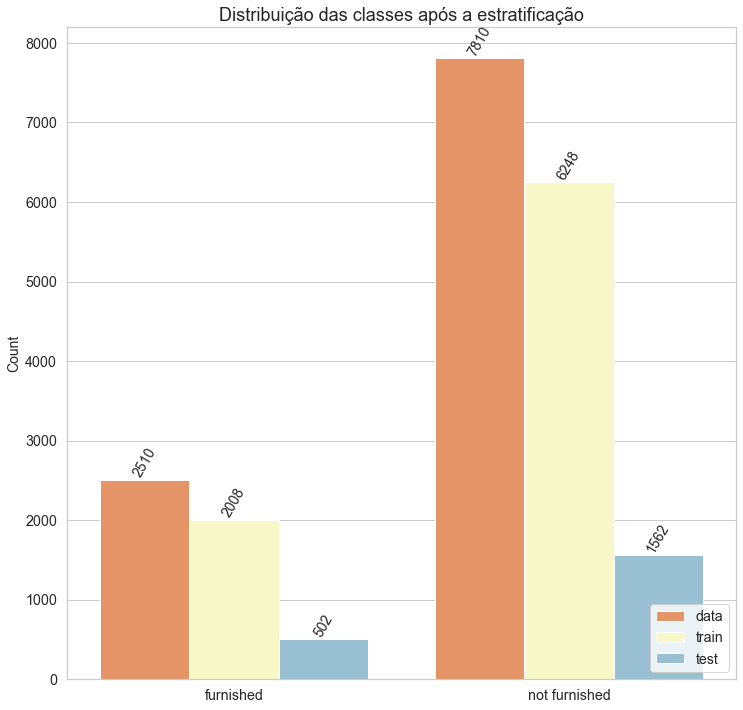

In [31]:
# Verificando a estratificação
utils.plot_labels_distribution("Distribuição das classes após a estratificação",
                               y_furniture,
                               y_train_furniture,
                               y_test_furniture,
                               labels=["furnished", "not furnished"])

In [32]:
label_furniture = 'furniture'
classif_furniture_models_dir = MODELS_BASE_DIR + "/Classification/Furniture"
classif_furniture_grids_dir = GRIDS_BASE_DIR + "/Classification/Furniture" 
classif_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Criação das Grids Search e seleção dos melhores modelos de acordo com o F1
best_classification_furniture_models = models.train_classification_models(needs_to_train=True, # Carrega os modelos treinados
                                                                          models_path=classif_furniture_models_dir,
                                                                          X_train=X_train_furniture, 
                                                                          y_train=y_train_furniture, 
                                                                          score_metrics=classif_score_metrics, 
                                                                          cv=classif_cv, 
                                                                          best_criteria=classif_best_criteria, 
                                                                          grids_path=classif_furniture_grids_dir, 
                                                                          label=label_furniture)
best_classification_furniture_models

[DONE] Treino e geração da GridSearch do modelo Regressão Logística --> 12.600809097290039 segundos
[DONE] Treino e geração da GridSearch do modelo KNN para Classificação --> 88.15765380859375 segundos
[DONE] Treino e geração da GridSearch do modelo Árvore de Decisão para Classificação --> 0.35907506942749023 segundos
[DONE] Treino e geração da GridSearch do modelo Naive Bayes para Classificação --> 0.25694918632507324 segundos
[DONE] Treino e geração da GridSearch do modelo SVM para Classificação --> 160.66353511810303 segundos

Salvando os resultados das grids search de cada modelo...
Salvando os melhores modelos...


{'furniture_logistic_regression': Pipeline(steps=[('scaler', StandardScaler()),
                 ('LR',
                  LogisticRegression(C=0.001, penalty='none',
                                     solver='newton-cg'))]),
 'furniture_knn': Pipeline(steps=[('scaler', StandardScaler()),
                 ('KNN',
                  KNeighborsClassifier(metric='chebyshev', weights='distance'))]),
 'furniture_decision_tree': DecisionTreeClassifier(),
 'furniture_naive_bayes': GaussianNB(var_smoothing=1e-11),
 'furniture_svc': Pipeline(steps=[('scaler', StandardScaler()),
                 ('SVC',
                  BaggingClassifier(base_estimator=SVC(C=100, gamma='auto'),
                                    max_samples=0.06666666666666667,
                                    n_estimators=15))])}

#### Regressão Logística

As **combinações de hiperparâmetros** utilizadas se tratam das mesmas que foram escolhidas para a classificação do atributo `animal`.

In [33]:
df_grid_logreg_furniture = pd.read_csv(classif_furniture_grids_dir + '/' + label_furniture + '_logistic_regression.csv')
# Temos que dropar valores NaN pois, para fazermos todas as combinações possíveis, dependendendo dos parâmetros, 
# alguns modelos falham ao realizar o fit
  # Por exemplo: o solver lbfgs não consegue lidar com as penalties L1 ou ElasticNet
df_grid_logreg_furniture.dropna(inplace=True)
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_logreg_furniture)))
df_grid_logreg_furniture

Quantidade de combinações possíveis dos modelos da grid = 90 modelos


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1_score,mean_test_log_loss,params
0,0.757631,0.509298,0.101591,0.169331,-8.371154,"{'LR__C': 0.001, 'LR__penalty': 'none', 'LR__s..."
1,0.757631,0.509298,0.101591,0.169331,-8.371154,"{'LR__C': 25, 'LR__penalty': 'l2', 'LR__solver..."
2,0.757631,0.509298,0.101591,0.169331,-8.371154,"{'LR__C': 1, 'LR__penalty': 'none', 'LR__solve..."
3,0.757631,0.509298,0.101591,0.169331,-8.371154,"{'LR__C': 25, 'LR__penalty': 'l2', 'LR__solver..."
4,0.757631,0.509298,0.101591,0.169331,-8.371154,"{'LR__C': 1, 'LR__penalty': 'none', 'LR__solve..."
...,...,...,...,...,...,...
85,0.756783,0.333333,0.001495,0.002975,-8.400420,"{'LR__C': 0.001, 'LR__penalty': 'l2', 'LR__sol..."
86,0.756783,0.333333,0.001495,0.002975,-8.400420,"{'LR__C': 0.001, 'LR__penalty': 'l2', 'LR__sol..."
87,0.756783,0.333333,0.001495,0.002975,-8.400420,"{'LR__C': 0.001, 'LR__penalty': 'l2', 'LR__sol..."
88,0.756783,0.000000,0.000000,0.000000,-8.400419,"{'LR__C': 0.001, 'LR__penalty': 'l1', 'LR__sol..."


#### KNN

As **combinações de hiperparâmetros** utilizadas se tratam das mesmas que foram escolhidas para na tarefa de Regressão e na classificação do atributo `animal`.


In [34]:
df_grid_knn_furniture = pd.read_csv(classif_furniture_grids_dir + '/' + label_furniture + '_knn.csv')
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_knn_furniture)))
df_grid_knn_furniture.head()

Quantidade de combinações possíveis dos modelos da grid = 60 modelos


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1_score,mean_test_log_loss,params
0,0.741885,0.453511,0.299810,0.360810,-8.915057,"{'KNN__metric': 'chebyshev', 'KNN__n_neighbors..."
1,0.740916,0.448607,0.286862,0.349870,-8.948523,"{'KNN__metric': 'euclidean', 'KNN__n_neighbors..."
2,0.747335,0.467589,0.278391,0.348706,-8.726792,"{'KNN__metric': 'chebyshev', 'KNN__n_neighbors..."
3,0.737161,0.437412,0.284874,0.344877,-9.078214,"{'KNN__metric': 'manhattan', 'KNN__n_neighbors..."
4,0.748910,0.471692,0.271418,0.344477,-8.672404,"{'KNN__metric': 'euclidean', 'KNN__n_neighbors..."


#### Árvores de Decisão

As **combinações de hiperparâmetros** utilizadas se tratam das mesmas que foram escolhidas para a classificação do atributo `animal`.

In [35]:
df_grid_dt_furniture = pd.read_csv(classif_furniture_grids_dir + '/' + label_furniture + '_decision_tree.csv')
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_dt_furniture)))
df_grid_dt_furniture.head()

Quantidade de combinações possíveis dos modelos da grid = 4 modelos


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1_score,mean_test_log_loss,params
0,0.696948,0.381254,0.396923,0.388834,-10.467182,"{'criterion': 'gini', 'splitter': 'best'}"
1,0.689559,0.370929,0.397419,0.383662,-10.722380,"{'criterion': 'gini', 'splitter': 'random'}"
2,0.695979,0.376587,0.379978,0.378175,-10.500647,"{'criterion': 'entropy', 'splitter': 'best'}"
3,0.687379,0.364770,0.384460,0.374349,-10.797681,"{'criterion': 'entropy', 'splitter': 'random'}"


#### Naive Bayes

As **combinações de hiperparâmetros** utilizadas se tratam das mesmas que foram escolhidas para a classificação do atributo `animal`.

In [36]:
df_grid_nb_furniture = pd.read_csv(classif_furniture_grids_dir + '/' + label_furniture + '_naive_bayes.csv')
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_nb_furniture)))
df_grid_nb_furniture.head()

Quantidade de combinações possíveis dos modelos da grid = 5 modelos


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1_score,mean_test_log_loss,params
0,0.713421,0.397127,0.344621,0.368880,-9.898205,{'var_smoothing': 1e-11}
1,0.716085,0.399989,0.335156,0.364623,-9.806165,{'var_smoothing': 1e-10}
2,0.728077,0.405933,0.253485,0.312053,-9.391975,{'var_smoothing': 1e-09}
3,0.735586,0.379970,0.133468,0.196640,-9.132571,{'var_smoothing': 1e-08}
4,0.738493,0.369238,0.100602,0.157256,-9.032158,{'var_smoothing': 1e-07}


#### SVM

As **combinações de hiperparâmetros** utilizadas se tratam das mesmas que foram escolhidas para na tarefa de Regressão e na classificação do atributo `animal`.

In [37]:
df_grid_svc_furniture = pd.read_csv(classif_furniture_grids_dir + '/' + label_furniture + '_svc.csv')
print('Quantidade de combinações possíveis dos modelos da grid = {} modelos'.format(len(df_grid_svc_furniture)))
df_grid_svc_furniture.head()

Quantidade de combinações possíveis dos modelos da grid = 32 modelos


,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1_score,mean_test_log_loss,params
0,0.776042,0.584962,0.274895,0.373763,-7.735285,"{'SVC__base_estimator__C': 100, 'SVC__base_est..."
1,0.774588,0.583960,0.259468,0.358863,-7.785485,"{'SVC__base_estimator__C': 100, 'SVC__base_est..."
2,0.766352,0.540737,0.261953,0.352843,-8.069968,"{'SVC__base_estimator__C': 100, 'SVC__base_est..."
3,0.767078,0.544787,0.254967,0.346792,-8.044865,"{'SVC__base_estimator__C': 100, 'SVC__base_est..."
4,0.732074,0.409275,0.228117,0.290548,-9.253913,"{'SVC__base_estimator__C': 100, 'SVC__base_est..."
